Create an requirements files

In [38]:
%%writefile requirements.txt

torch==2.5.1
torchvision==0.20.1
opencv-python==4.10.0.84
matplotlib==3.8.2
seaborn==0.13.2
scikit-learn==1.4.1.post1
kagglehub==0.3.5


Overwriting requirements.txt


Install all the dependecy

In [39]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#Import all the required libraries

In [5]:
from torchvision.models import vgg11_bn, VGG11_BN_Weights
from torch import nn
import cv2
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import kagglehub

C:\Users\Co Chau\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Check if cuda is available

In [6]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
  print("cuda is not available")

# Download and load the dataset

Using kagglehub api, we can download the dataset

In [7]:
path = kagglehub.dataset_download("prasunroy/natural-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Co Chau\.cache\kagglehub\datasets\prasunroy\natural-images\versions\1


#Set path to the images folder

In [8]:
path = f"{path}/natural_images/"

With the image path, we can load the images and their respective classes into a dataset base on the name of the folder that the images reside. We can do this using the ImageFolder function provided by torchvision. The images also need to be transform. They will need to be resized since they are all of different sizes. The size chosen here is 224 by 224 since it is the dimension that the vgg model take. They are then transform into tensor so that they can be loaded into dataloader via torch dataloader.

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)
dataset = ImageFolder(path, transform=transform)
train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size
train_data, test_data = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = DataLoader(test_data, shuffle=False, batch_size=32)

Load a few images to see what they look like as well as their respective classes.

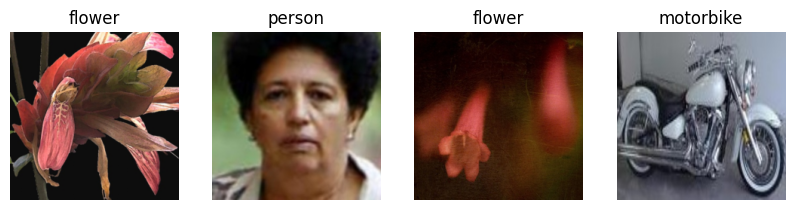

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(10, 44))
for x, y in train_loader:
  for i in range(4):
    image = x[i].permute(1, 2, 0)
    axs[i].set_title(dataset.classes[y[i]])
    axs[i].imshow(image)
    axs[i].axis('off')
  break

In [11]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 6899
    Root location: C:\Users\Co Chau\.cache\kagglehub\datasets\prasunroy\natural-images\versions\1/natural_images/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


Create a list of class count so that the distribution of each class in the dataset can be computed

In [12]:
class_count = [0] * 8

In [13]:
for images, classes in dataset:
  class_count[classes] += 1

In [14]:
class_count = [count/len(dataset)*100 for count in class_count]

Display the Image class distribution plot.

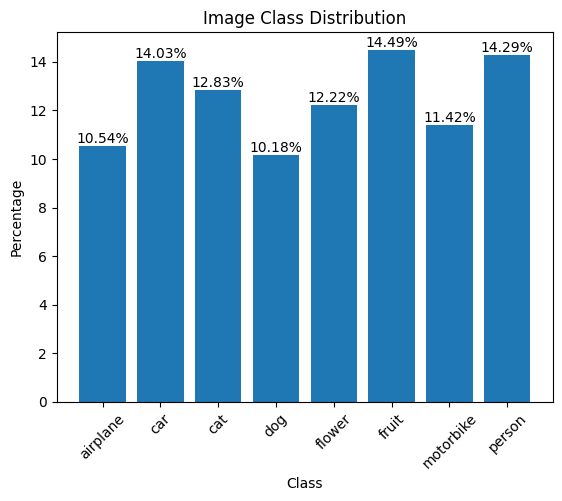

In [15]:
plt.bar(dataset.classes, class_count)
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Image Class Distribution')
for i, v in enumerate(class_count):
      plt.text(i, v, f"{v:.2f}%", ha='center', va='bottom')
plt.xticks(rotation=45)
plt.show()

As we can see, the data is fairly distributed among the classes.

# Load the pretrained model and modify for our case

We will use transfer learning for this problem. For this specific problem we will use the pretrained vgg11 model with the VGG11_BN_Weights pretrained weight

In [16]:
model = vgg11_bn(weights=VGG11_BN_Weights)

C:\Users\Co Chau\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Show an overview of the model

In [17]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Show the model classifier part

In [18]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Since the pretrained model classifier have an output feature of 1000 classes, we will need to create a custom classifier module with 8 output features classes to fit our dataset and replace the original classifier with our custom made classifier module.

Our CustomClassifier module will be 5 simple dense layer activated with ReLU activation function with dropout. with the first layer having the number of input features matching the original classifier input features.


In [19]:
class CustomClassifier(nn.Module):
  def __init__(self):
    super(CustomClassifier, self).__init__()
    self.dense1 = nn.Linear(in_features=25088, out_features=256)
    self.dense2 = nn.Linear(in_features=256, out_features=128)
    self.dense3 = nn.Linear(in_features=128, out_features=8)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    layer1 = self.dropout(self.activation(self.dense1(x)))
    layer2 = self.dropout(self.activation(self.dense2(layer1)))
    out = self.dense3(layer2)
    return out

Now that we created our custom classifier, we have to change the model classifier to our custom classifier

In [20]:
model.classifier = CustomClassifier()

In [21]:
model.classifier

CustomClassifier(
  (dense1): Linear(in_features=25088, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=8, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [22]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Let's see how many trainable parameter that we have.

In [23]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 15682696


There is a lot of trainable parameters. Lets set the gradient to false for the features part and the avg pool part of the model since we only have about 5000 training images. Our goal is to train a classifier for our dataset.

In [24]:
for param in model.features.parameters():
  param.requires_grad = False
for param in model.avgpool.parameters():
  param.requires_grad = False

In [25]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 6456712


# Training

We will use adam optimizer from pytorch. Since this is a classification problem, the loss function that we use will be cross entropy loss.
we will set our model device to cuda to take advantage of the gpu.

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_function = nn.CrossEntropyLoss()
model.to(device)
current_epoch = 0

Define the train one epoch function as recommended by the official pytorch documentation for training pytorch model.

In [27]:
def train_one_epoch(model, train_loader, optimizer, device):
  avg_train_loss = 0.
  last_loss = 0.
  correct = 0
  total = 0
  for i, data in enumerate(train_loader):
    images, classes = data
    classes = classes.to(device)
    images = images.to(device)
    optimizer.zero_grad()
    logits = model(images)
    predicted = torch.argmax(logits, dim=1)
    total += classes.size(0)
    correct += (predicted == classes).sum().item()
    loss = loss_function(logits, classes)
    loss.backward()
    optimizer.step()
    running_loss = loss.item()
    last_loss += running_loss
  train_accuracy = 100 * correct / total
  avg_train_loss = last_loss / (i+1)
  print(f" Train Total: {total} Correct: {correct} Accuracy: {train_accuracy:.2f}")
  return avg_train_loss, train_accuracy

Define our training loop function which we can pass the number of epoch in. This function will return the loss history as well as the accuracy history which we will use to plot the graph later.

In [28]:
def run_train_loop(model, train_loader, test_loader, optimizer, device, num_epoch, cur_epoch):
    epoch_number = 0
    EPOCHS = num_epoch
    avg_train_loss_history = []
    avg_test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    for epoch in range(EPOCHS):
        print("EPOCH {}:".format(epoch_number+1+cur_epoch))
        model.train(True)
        avg_train_loss, train_accuracy = train_one_epoch(model=model, train_loader=train_loader, \
                                         optimizer=optimizer, device=device)
        running_test_loss = 0.0
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i, test_data in enumerate(test_loader):
                test_images, test_classes = test_data
                test_images = test_images.to(device)
                test_classes = test_classes.to(device)
                test_logits = model(test_images)
                predicted = torch.argmax(test_logits, dim=1)
                total += test_classes.size(0)
                correct += (predicted == test_classes).sum().item()
                test_loss = loss_function(test_logits, test_classes)
                running_test_loss += test_loss.item()
                # print(" Batch {} test loss: {} Time elapsed: {}".format(i+1, test_loss, time_elapse(time_start)))
        accuracy = 100 * correct / total
        avg_test_loss = running_test_loss/(i+1)
        print(f" Test Total: {total} Correct: {correct} Accuracy: {accuracy:.2f}")
        print(f" Average train loss: {avg_train_loss:2.8f}")
        print(f" Average test loss: {avg_test_loss:2.8f}")
        avg_train_loss_history.append(avg_train_loss)
        avg_test_loss_history.append(avg_test_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(accuracy)
        epoch_number += 1
    cur_epoch += epoch_number
    return cur_epoch, avg_train_loss_history, avg_test_loss_history, train_accuracy_history, test_accuracy_history


Initialize the list that will hold the loss and the accuracy history.

In [29]:
avg_train_loss_history = []
avg_test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Run the training loop function.

In [30]:
current_epoch, avg_train_loss_history, avg_test_loss_history, train_accuracy_history, \
test_accuracy_history = run_train_loop(model, train_loader, test_loader, optimizer, device, 10, current_epoch)

EPOCH 1:
 Train Total: 5519 Correct: 4330 Accuracy: 78.46
 Test Total: 1380 Correct: 1359 Accuracy: 98.48
 Average train loss: 1.53308790
 Average test loss: 0.85658123
EPOCH 2:
 Train Total: 5519 Correct: 5351 Accuracy: 96.96
 Test Total: 1380 Correct: 1365 Accuracy: 98.91
 Average train loss: 0.64265910
 Average test loss: 0.31917857
EPOCH 3:
 Train Total: 5519 Correct: 5427 Accuracy: 98.33
 Test Total: 1380 Correct: 1368 Accuracy: 99.13
 Average train loss: 0.31096686
 Average test loss: 0.15750886
EPOCH 4:
 Train Total: 5519 Correct: 5444 Accuracy: 98.64
 Test Total: 1380 Correct: 1369 Accuracy: 99.20
 Average train loss: 0.18472511
 Average test loss: 0.09606257
EPOCH 5:
 Train Total: 5519 Correct: 5464 Accuracy: 99.00
 Test Total: 1380 Correct: 1371 Accuracy: 99.35
 Average train loss: 0.12522269
 Average test loss: 0.06724119
EPOCH 6:
 Train Total: 5519 Correct: 5470 Accuracy: 99.11
 Test Total: 1380 Correct: 1373 Accuracy: 99.49
 Average train loss: 0.09326432
 Average test los

Plot the loss of Training vs Testing

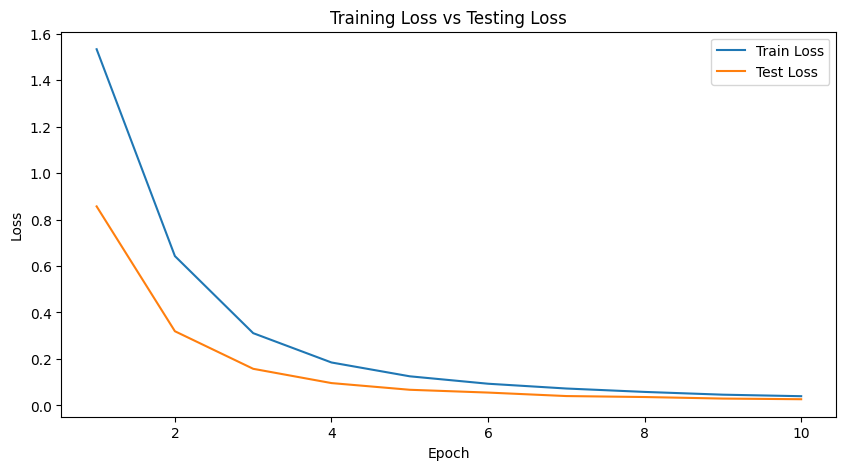

In [31]:
plt.figure(figsize=(10, 5))
x = range(1, len(avg_train_loss_history)+1)
plt.plot(x, avg_train_loss_history, label='Train Loss')
plt.plot(x, avg_test_loss_history, label='Test Loss')
plt.title('Training Loss vs Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the accuracy, training vs testing set

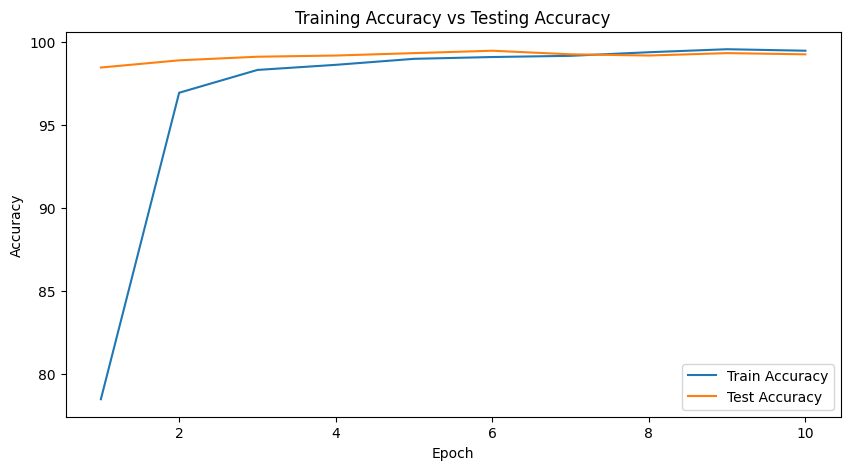

In [32]:
plt.figure(figsize=(10, 5))
x = range(1, len(train_accuracy_history)+1)
plt.plot(x, train_accuracy_history, label='Train Accuracy')
plt.plot(x, test_accuracy_history, label='Test Accuracy')
plt.title('Training Accuracy vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test the model prediction in one of the batch of data

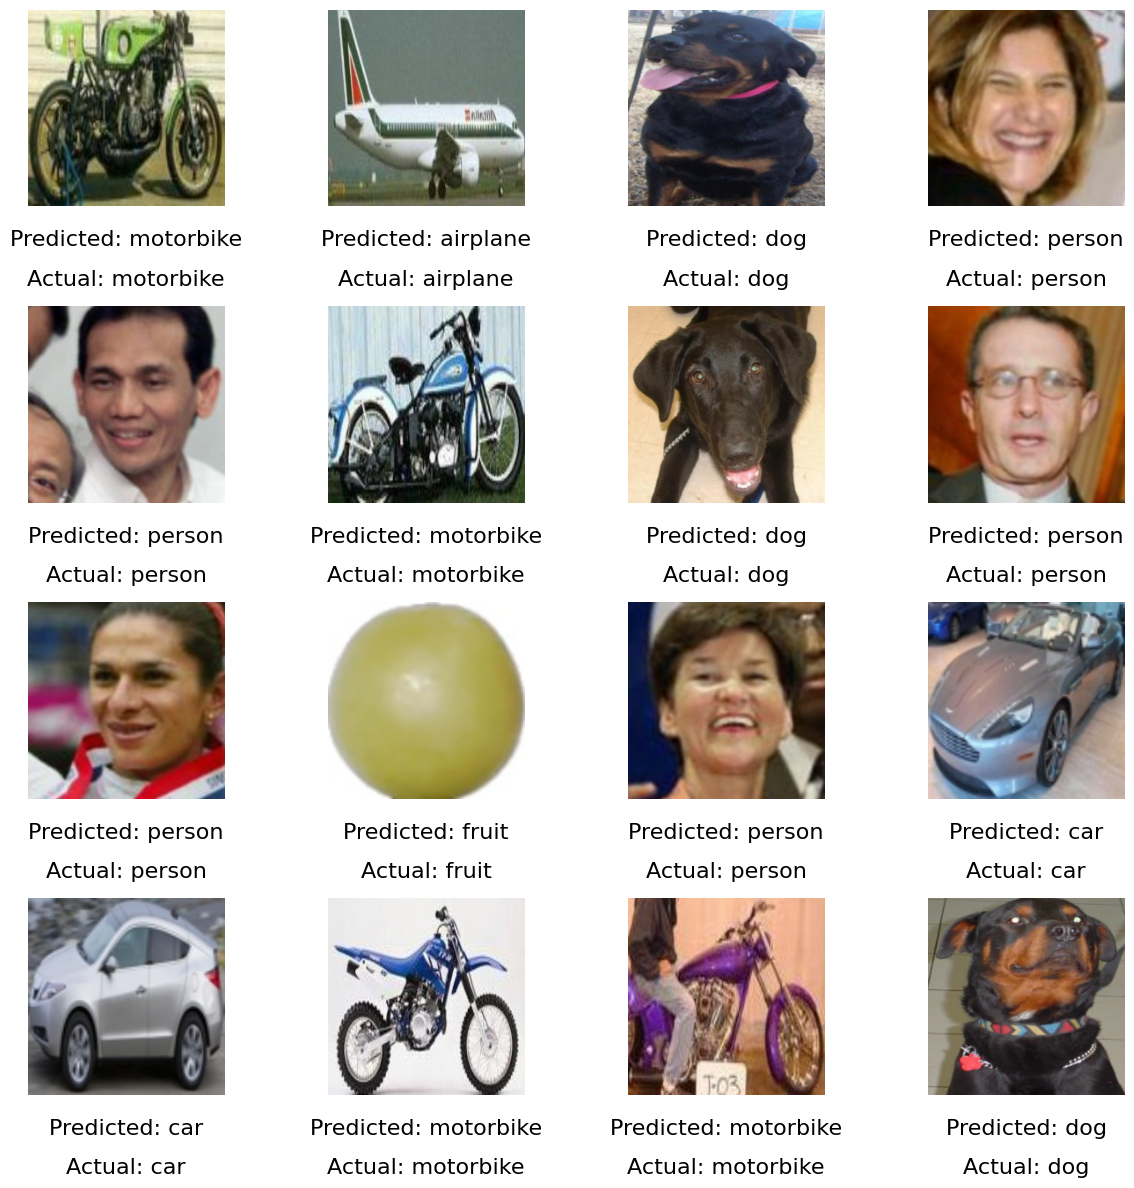

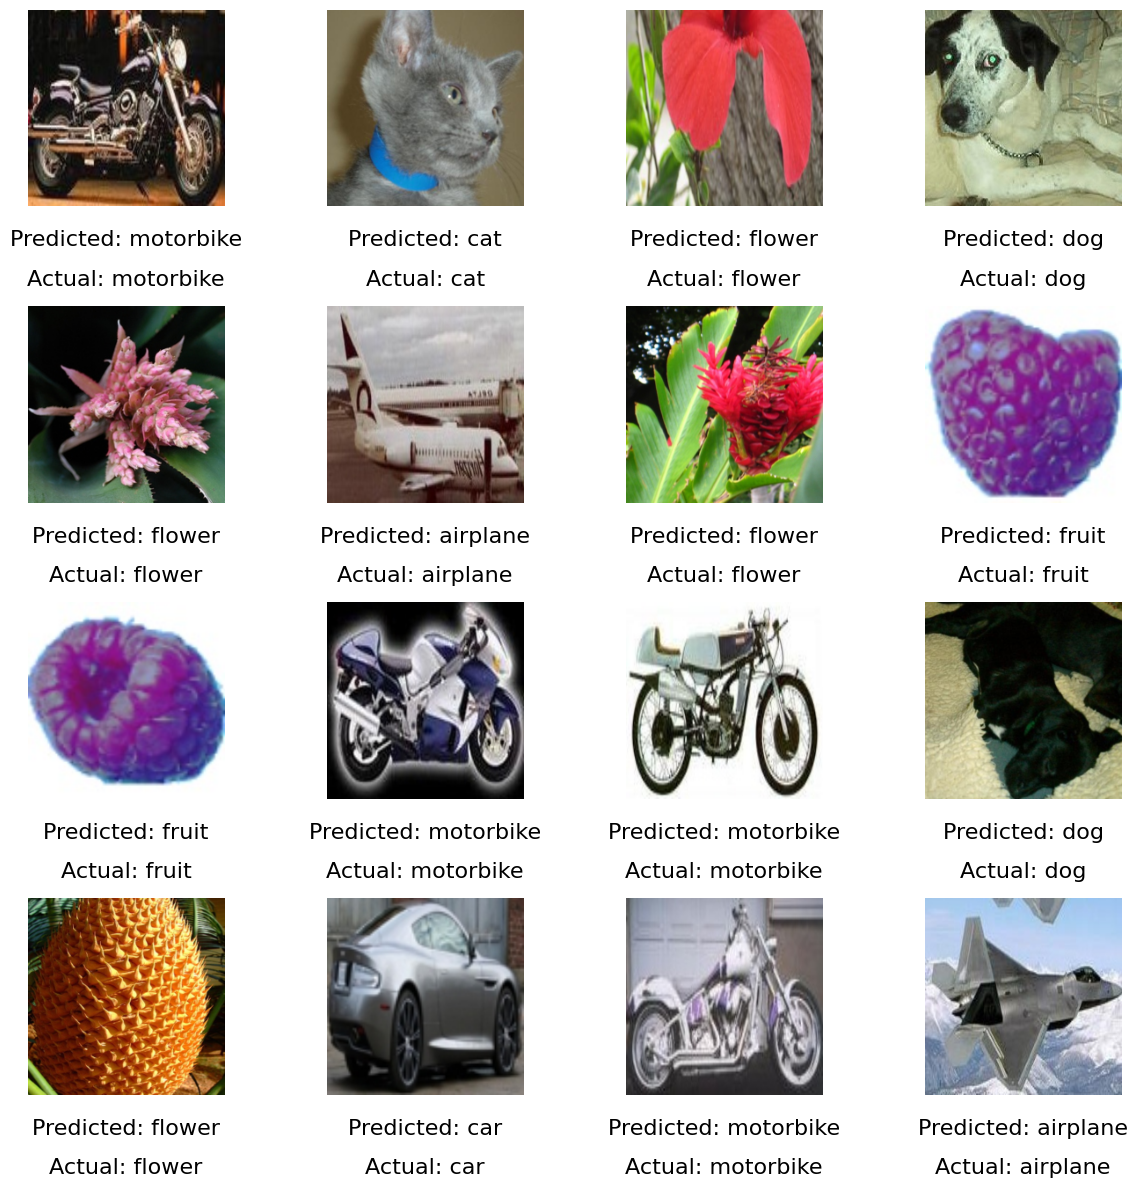

In [33]:
for i, data in enumerate(test_loader):
  images, classes = data
  images = images.to(device)
  classes = classes.to(device)
  logits = model(images)
  predicted = torch.argmax(logits, dim=1)
  for j in range(0, 32, 16):
    fig, axs = plt.subplots(4, 4, figsize = (12, 12))
    axs = axs.flatten()
    for k in range(16):
      index = j+k
      axs[k].imshow(images[index].detach().cpu().numpy().transpose(1, 2, 0))
      axs[k].axis("off")
      # Use text annotations
      axs[k].text(0.5, -0.2, f"Predicted: {dataset.classes[predicted[index]]}",
                  transform=axs[k].transAxes, ha="center", fontsize=16)
      axs[k].text(0.5, -0.4, f"Actual: {dataset.classes[classes[index]]}",
                  transform=axs[k].transAxes, ha="center", fontsize=16)

    plt.tight_layout()
    plt.show()
  break

Create 2 lists, for holding the prediction from the model and the actual classes. The two list will be used to create our confusion matrix.

In [34]:
prediction = []
classes = []

In [35]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Using sns heatmap, and confusion_matrix function from sklearn, we can create our confusion matrix.

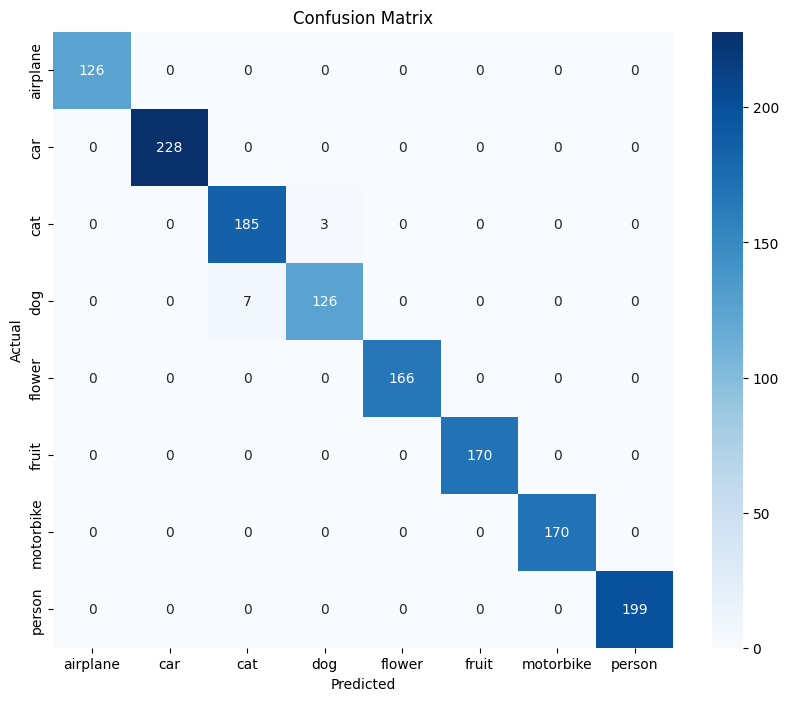

In [36]:
with torch.no_grad():
  for i, data in enumerate(test_loader):
    images, classes_ = data
    images = images.to(device)
    classes_ = classes_.to(device)
    logits = model(images)
    predicted = torch.argmax(logits, dim=1)
    prediction.extend(predicted.cpu().numpy())
    classes.extend(classes_.cpu().numpy())

prediction = torch.tensor(prediction)
classes = torch.tensor(classes)

num_classes = len(dataset.classes)
conf_mat = confusion_matrix(classes, prediction, labels=range(num_classes))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
class_report = classification_report(classes, prediction, target_names=dataset.classes)
print(class_report)

              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       126
         car       1.00      1.00      1.00       228
         cat       0.96      0.98      0.97       188
         dog       0.98      0.95      0.96       133
      flower       1.00      1.00      1.00       166
       fruit       1.00      1.00      1.00       170
   motorbike       1.00      1.00      1.00       170
      person       1.00      1.00      1.00       199

    accuracy                           0.99      1380
   macro avg       0.99      0.99      0.99      1380
weighted avg       0.99      0.99      0.99      1380

